# Sheet 2 - Simulation exercise (Gaussian mixture model - Gibbs sampling) 

In [1]:
using Distributions, StatsPlots, Plots, StatsBase
using GaussianMixtures
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

## Sample synthetic dataset from mixture model.

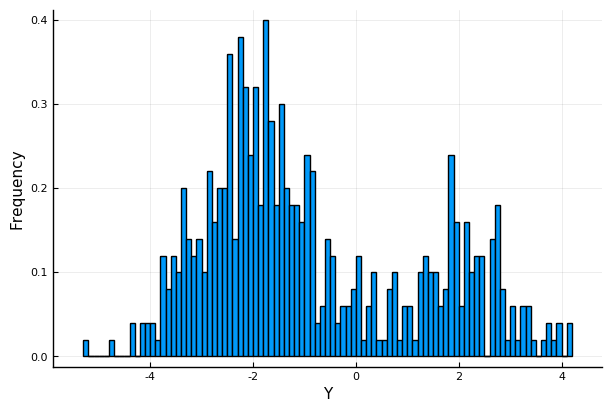

In [1418]:
mu0    = [-2,2]
sigma2= [1,1]
p0     = [0.7,0.3]
w = Weights(p0)
M = 500
X = zeros(M)
s = sample(1:2, w,M)
for i = 1:M
    j = s[i]
    X[i]+= rand(Normal(mu0[j],sigma2[j]))
end

p = histogram(X,xlabel="Y",ylabel="Frequency",normalize=true,legend=false,nbins=100)
savefig(p,"./images/Ex6.png")

In [1441]:
fit_mle(Normal,X)

Normal{Float64}(μ=-0.8678632907213235, σ=2.0548420236477045)

### Initial step:
* Sample from prior p      ~ Dirichlet
* Sample from prior μk     ~ N(m, tau^2)
* Sample from prior sig2_k ~ IG(alpha, beta)

### After that, sample from the full conditionals:
* Sample Z | p, mu, sig2 , Y ~ P(Z_i = k | p,y,mu,sig2) = p_k*pdf(Normal(mu,sig),y)
* Sample p1,...,pk | Z, mu, sig2, Y ~ Dirichlet (gamma1 + n1,...,gammak + nk)
* Sample sig2_1,...,sig2_k | Z, mu, p, Y $\sim
\text{Inverse Gamma}\left(
\alpha + \frac{n_k}{2}, \beta +
\frac{\sum_{i=1}^{n_k}(x_i - \mu_k)^2}{2}
\right)
$
* Sample mu_1, ... , mu_k | Z, sig2, p, Y$ \sim
N\left(
\frac{n_k \sigma_k ^{-2}\bar{x_k} + \tau^{-2}m}
{n_k\sigma^2_k}
, [n_k\sigma_k^{-2} + \tau^{-2}]^{-1}
\right)$

In [1442]:
y     = X
M = length(y)
k = 2
gamma, m, tau, alpha, beta = [1,1],-0.86,100,0.01,0.01
steps = 10000
posterior = zeros(steps,k*3)

p   = rand(Dirichlet(gamma))
mu  = rand(Normal(m,sqrt(tau)),k)
sig = 1 ./ (rand(Distributions.Gamma(alpha, beta^-1),k))
# sig = rand(InverseGamma(alpha,beta^(-1)),k)


for s=1:steps
    z = zeros(M)
    for i = 1:M
        w1 = p[1] * pdf(Normal(mu[1],sqrt(sig[1])),y[i])
        w2 = p[2] * pdf(Normal(mu[2],sqrt(sig[2])),y[i])
        z[i] += sample(1:k, Weights([w1,w2]))
    end
    n1 = sum(z .== 1)
    n2 = sum(z .== 2)
    sum1 = sum(y[z .== 1])
    sum2 = sum(y[z .== 2])

    p  = rand(Dirichlet(gamma + [n1,n2]))

    m_p1   = (1/(1/tau + n1/sig[1])) * (m/tau + sum1/sig[1])
    m_p2   = (1/(1/tau + n2/sig[2])) * (m/tau + sum2/sig[2])
    tau_p1 = (1/tau + n1/sig[1])^(-1)
    tau_p2 = (1/tau + n2/sig[2])^(-1)

    mu[1] = rand(Normal(m_p1,sqrt(tau_p1)))
    mu[2] = rand(Normal(m_p2,sqrt(tau_p2)))

    sumsq1= sum((y[z .== 1] .- mu[1]).^2)
    sumsq2= sum((y[z .== 2] .- mu[2]).^2)

    alpha1= alpha + 0.5*n1
    alpha2= alpha + 0.5*n2
    beta1 = beta  + 0.5*sumsq1
    beta2 = beta  + 0.5*sumsq2
    sig[1]= 1/(rand(Distributions.Gamma(alpha1, beta1^-1)))
    sig[2]= 1/(rand(Distributions.Gamma(alpha2, beta2^-1)))

    posterior[s,:] = posterior[s,:] + vcat(p,mu,sig)
    
end

#### Post-processing
Let's order the results by making mu1>mu2 and p1>p2

In [1443]:
p1 = zeros(steps)
p2 = zeros(steps)
mu1 = zeros(steps)
mu2 = zeros(steps)
sig1 = zeros(steps)
sig2 = zeros(steps)
for i = 1:steps
    if posterior[i,1] >= posterior[i,2]
    else
    end
end

for i = 1:steps
    if posterior[i,3] >= posterior[i,4]
        mu1[i] = posterior[i,3]
        mu2[i] = posterior[i,4]
        p1[i] = posterior[i,1]
        p2[i] = posterior[i,2]
        sig1[i] = posterior[i,5]
        sig2[i] = posterior[i,6]
    else
        mu1[i] = posterior[i,4]
        mu2[i] = posterior[i,3]
        p1[i] = posterior[i,2]
        p2[i] = posterior[i,1]
        sig1[i] = posterior[i,6]
        sig2[i] = posterior[i,5]
    end
end



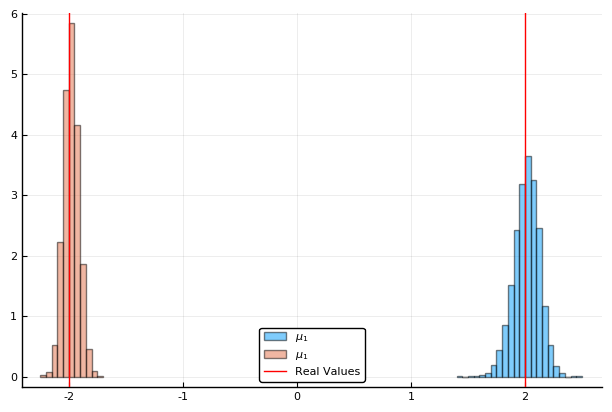

In [1477]:
histogram(mu1[5000:end],normalize=true,alpha=0.5,nbins=20, label = L"μ_1")
histogram!(mu2[5000:end],normalize=true,alpha=0.5,nbins=20, label = L"μ_1")
h2 = vline!(mu0,color="red", label="Real Values")
savefig(h2,"./images/Ex8_1.png")

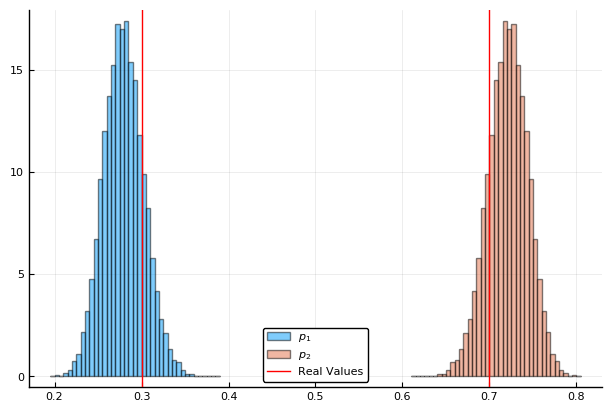

In [1478]:
histogram(p1[1000:end],normalize=true,alpha=0.5,label=L"p_1")
histogram!(p2[1000:end],normalize=true,alpha=0.5, label=L"p_2")
h = vline!(p0,color="red",label="Real Values")
savefig(h,"./images/Ex8_2.png")

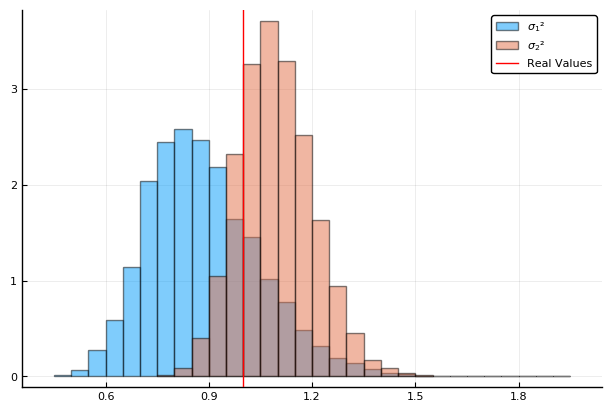

In [1481]:
histogram(sig1[5000:end],normalize=true,alpha=0.5,nbins=30, label=L"\sigma_1²")
histogram!(sig2[5000:end],normalize=true,alpha=0.5,nbins=30, label=L"\sigma_2²")
h = vline!([1],color="red", label="Real Values")

savefig(h,"./images/Ex8_3.png")

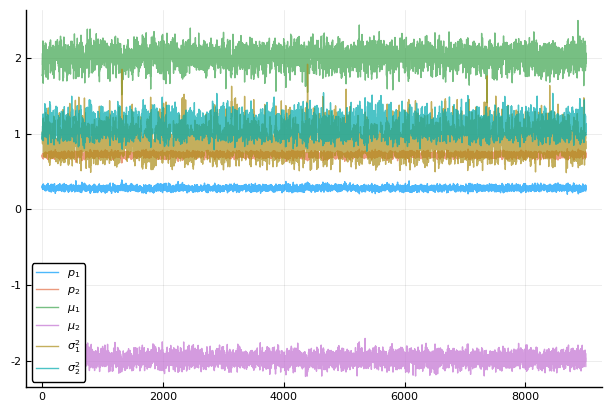

In [1480]:
plot(p1[1000:end],normalize=true,  alpha=0.7,label=L"p_1")
plot!(p2[1000:end],normalize=true,  alpha=0.7,label=L"p_2")
plot!(mu1[1000:end],normalize=true,  alpha=0.7,label=L"\mu_1")
plot!(mu2[1000:end],normalize=true, alpha=0.7,label=L"\mu_2")
plot!(sig1[1000:end],normalize=true,alpha=0.7,label=L"σ_1^2")
f = plot!(sig2[1000:end],normalize=true,alpha=0.7,label=L"σ_2^2")

savefig(f,"./images/Ex8_4.png")